# Data and Analysis Plan: Job Board Analysis
## Team 5

- List
- Group
- Names
- Here

## Project Goal:
This project aims to use data scraped from public job listing sites in order to understand what qualities hiring softwares expects from candidates. By analyzing keywords from job descriptions by industry we will be able to show words for candidates to use on their resumes when applying.

## Data 

### Overview 
We will scrape a [list of job recommendations](https://www.indeed.com/jobs?q=engineering&l=Boston&vjk=e2c71c08db89b4c5) on Indeed, a job listing site, for a variety of jobs in the city of Boston. Our framework will be built on job industries such as engineering, consulting, marketing, finance, etc. and then later on we will adapt our pipeline to allow for narrowed down searches by job titles.

<img src="https://d341ezm4iqaae0.cloudfront.net/assets/2020/04/06151541/JanusScreenshot-Cropped-747x364.png" width=800px>


From this list, for each job, we can obtain information including:
- Job Title
- Company

Upon visiting the individual webpages for each job, the job description can be accessed as well, as shown on the right side of the image above.

For each description, keywords will be collected: 
Keywords will be filtered out from each job description using the Natural Language Toolkit (NLTK) platform and its provided stopwords. 
Criteria for keywords such as word length and description specific stopwords will be implemented in order to filter out words that aren’t useful, some examples being:
- Education
- Required
- Experience
- Apply
- Work
- Job

Keywords from each job description will be organized into a dataframe with their respective Position TItle and Company.  Keywords from all of the descriptions will also be pooled together in order to obtain a list of the most frequent words from each given search. 



### Pipeline Overview

We will accomplish this task with the following functions:

#### Webscraping and Formatting Data
- `jobs_soup()`
    - build url and return soup object
- `job_type()`
    - returns the job position scraped from Indeed
- `company_name()`
    - returns the company name scraped from Indeed
- `get_href_job()`
    - returns list of urls for link to each specific job
- `get_href_soup()`
    - returns soup object from provided url
- `job_descriptions()`
    - returns the individual job description scraped from Indeed
    
#### NLP
- `tokenize()`
    - clean up string using NLP
- `get_top_n_words()`
    - exctract most common words from group of job descriptions

### Pipeline
#### Webscraping and Formatting Data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
def jobs_soup(search, location):
    ''' gets html content for given search on indeed.com
    
    Args:
        search (str): position or industry
        location (str): desired job location
    
    Returns:
        soup (soup obj): object containing html content
        of the given search
    '''
    
    # make url
    url = f'https://www.indeed.com/q-{search}-l-{location}-jobs.html'
    response = requests.get(url).text
    
    # get response and make soup
    soup = BeautifulSoup(response)
    return soup

In [3]:
def job_type(soup):
    ''' creates list of job titles from soup object
    
    Args:
        soup (soup obj): object containing html content
        of the given search
    
    Returns:
        job_lst (list): list of all job titles found in html 
        content
    '''
    
    job_lst = []
    
    # find job titles in html
    for item in soup.find_all('h2', class_ = 'jobTitle'):
        job_lst.append(item.text.replace('new', ''))
    
    return job_lst

In [4]:
def company_name(soup):
    ''' creates list of company names from soup object
    
    Args:
        soup (soup obj): object containing html content
        of the given search
    
    Returns:
        name_lst (list): list of all companies found in html 
        content
    '''
    
    name_lst = []
    
    # find company name in html.
    for item in soup.find_all(class_ = 'heading6 company_location tapItem-gutter companyInfo'):
        name_lst.append(item.span.text)
        
    return name_lst

In [5]:
def get_href_job(soup):
    ''' formats a url for each job in html content
    
    Args:
        soup (soup obj): object containing html content
        of the given search
    
    Returns:
        href_lst (list): list of all of urls for each job
        specific listing from html content
    '''
    
    # find href to own page in html
    
    job_id_lst = []
    href_lst = []
    job = soup.find(id = 'mosaic-provider-jobcards')
    
    # find the specific job ids (each have own class/id)
    job_ids = job.find_all('a', id=True)
    
    # make list of the job ids
    for i in range(0, len(job_ids)):
        job_id_lst.append(job_ids[i]['id'])
    
    # get the href from each specific job
    for val in job_id_lst:
        spec_job = job.find(id = val)
        spec_job.find('a', href=True)
        
        # add indeed.com to link
        href_lst.append('http://indeed.com' + spec_job['href'])
   
    return href_lst

In [6]:
def href_soup(url):
    '''gets text for a given url
    
    Args:
        url(str): url for a specific webpage
    
    Returns:
        soup (soup obj): html text content of given url
    '''
    response = requests.get(url).text
    
    # get response and make soup
    soup = BeautifulSoup(response)
    return soup

In [7]:
def job_descriptions(hrefs):
    ''' creates list of job description text
    
    Args:
        hrefs (list): list of urls containing job descriptions
        on their webpage
    
    Returns:
        descriptions (list): list of all job descriptions found 
        for each url given
    '''
    descriptions = []
    
    # loop through each href, get soup for it
    for url in hrefs:
        new_soup = href_soup(url)
        descriptions.append(new_soup.find(id = 'jobDescriptionText').text)
    
    return descriptions

In [8]:
# call functions in pipeline
soup = jobs_soup('engineering', 'boston')
job_titles = job_type(soup)
companies = company_name(soup)
hrefs = get_href_job(soup)
descriptions = job_descriptions(hrefs)

# make dictionary with information scraped
jobs_dict = {'Position': job_titles,
             'Company': companies,
             'Description': descriptions}

# convert to dataframe
df_jobs = pd.DataFrame(jobs_dict)
df_jobs.head()

,Position,Company,Description
0,Engineering Officer Track & ROW,Massachusetts Bay Transportation Authority,"\n\n\n\n\n\nSalary \n\n\n\n\n\n $108,264...."
1,"Project Engineering Designer, Mechanical",EYP,\n\nResponsible for assisting in the productio...
2,Engineering Technician,"Vanu, Inc.","\nVanu Inc, a leader in Software Defined Radio..."
3,Mechanical Engineering I,Symmons Industries,\n\n Overview: \n \n Symmons Industries i...
4,Mechanical Engineer,MagiQ Technologies,Skills required include mechanical packaging o...


#### NLP

In [9]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import wordcloud as wc
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
import seaborn as sns

In [10]:
def tokenize(long_string):
    '''extracts keywords from a text string
    
    Args:
        long_string (str): long string containing text
    
    Returns:
        tokens (list): filtered list of all keywords from text
    '''

    # define stopwords (can be edited if needed)
    stopword = stopwords.words('english')

    # remove numbers from long string
    description = re.sub(r'\d+', '', long_string)

    # convert to lowercase and de-hyphenate words
    description = description.lower().replace('-', '')

    # nltk tokenizer setup
    tokenizer = RegexpTokenizer(r'\w+')

    # tokenize to list of words and remove stopwords
    tokens = tokenizer.tokenize(description)
    tokens = [word for word in tokens if word not in stopword]

    return tokens

In [11]:
def get_top_n_words(token, n=20):
    ''' get the top words from a job description in df
    Args:
        token (list): filtered list of all keywords from text
        n(int): specifies how many words the user want to see
        
    Returns: top_df (dataframe): datagrame of the top words
    '''
    
    # get the top key words 
    vec = CountVectorizer().fit(token)
    bag_of_words = vec.transform(token)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
        
    # convert most freq words to dataframe for plotting bar plot
    top_df = pd.DataFrame(words_freq[:n])
    top_df.columns=["Keyword", "Frequency"]
    
    return top_df

In [12]:
def make_wordcloud(df,industry,location,colormap = 'viridis',minlength=3):
    ''' creates wordcloud of words from a df
    
    Args:
        df (dataframe): dataframe containing text for wordcloud
        colormap (str): color pallette to randomly draw colors from
        for each word
        minlength(int): specifies how short words can be in word cloud
        text(str): caption explaining the wordcloud
    '''

    # create list of all key words provided in a given search query
    wordpool = []
    for row in df['Description']:
        tokens = tokenize(row)
        for word in tokens:
            wordpool.append(word)

    # produce wordcloud from list of words (must be joined into single string first to generate)
    cloud = wc.WordCloud(width=2000, height=1000, 
                         colormap=colormap, 
                         min_word_length=minlength, 
                         background_color ='white')
    plt.figure(dpi=200)
    querycloud = cloud.generate(" ".join(wordpool))
    plt.axis('off')
    plt.imshow(querycloud)
    plt.title(f'Most popular words for {industry} job descriptions in {location}')

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erikaackley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Visualizations (sanity check / data exploration)

#### Wordcloud

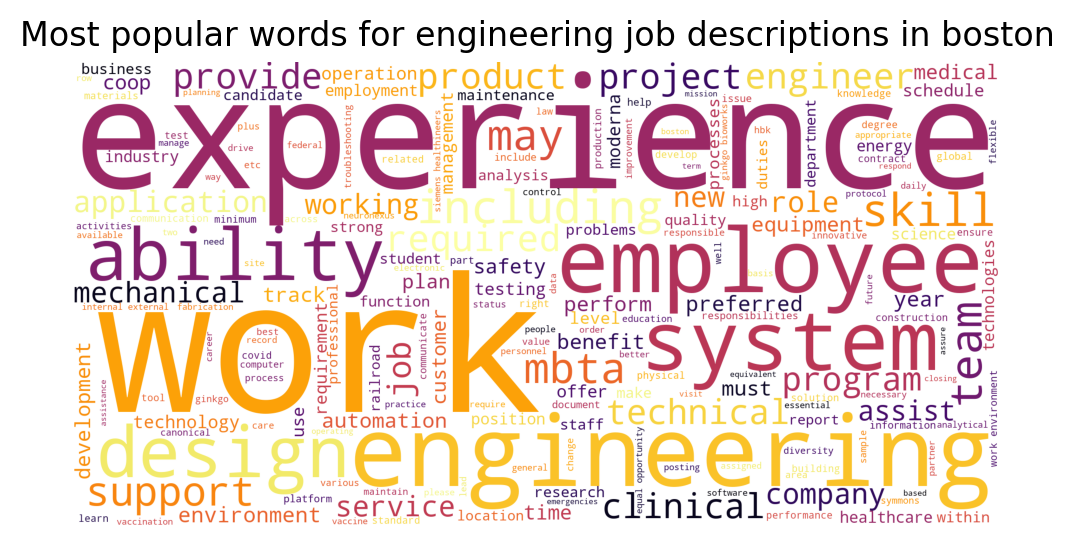

In [14]:
# create wordcloud
make_wordcloud(df_jobs,'engineering','boston', 'inferno')

In [17]:
def barplot(df,industry,location):
    ''' plot a bar graph of top keywords
    Args:
        df (dataframe): the dataframe of top keyword
    '''
    
    sns.set(rc={'figure.figsize':(13,8)})
    g = sns.barplot(x="Keyword", y="Frequency", data=df, palette="Blues_d")
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    plt.title(f'Keyword frequency distribution of {industry} job descriptions in {location}')

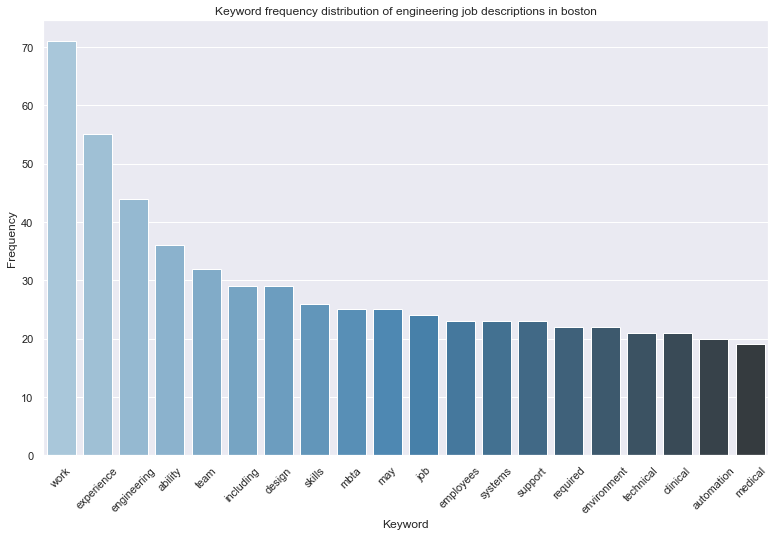

In [18]:
# create list of all keywords provided in a given search query
wordpool = []
for row in df_jobs['Description']:
    tokens = tokenize(row)
    for word in tokens:
        wordpool.append(word)

# plotting keyword frequency
top_df = get_top_n_words(wordpool, n=20)
barplot(top_df,'engineering','boston')

## Analysis Plan

Our assumption is that job descriptions for a given search (either industry group or specific title) all share a certain subset of keywords that hiring softwares are screening for when applicants submit resumes. 

A few algorithms and approaches can be used in order to determine what keywords an applicant should be using based on their specific search.

- K-Nearest Neighbors can be utilized to classify each “job search” with a group of keywords that are most common in job descriptions for that search. For example, if we wanted to classify “engineering manager”, a list of the top, most likely job description keywords would be produced for that applicant to use. This would be achieved using a classifier and training it on subsets of job description data for various searches.
    - Creating list of various types of job searches and locations
    - Determine the most important keywords from each type of search based on criteria (ie. frequency, length, parts of speech) and assigning them a class (ie. engineering, business, marketing, finance, etc.)
    - Convert text data to numerical data using vectorization
    - Predict the class of a job search (y-value) and show the keywords for that class
 

- Using Random Forest classification, based on decision tree algorithms, we can produce predictions on whether certain terms would be acceptable on a resume within a certain job field or for a position. The preparation to this method would be somewhat similar to K-Nearest Neighbors.
    - Develop a list of various job industries and positions we want to extract words for
    - Determine the most important and common keywords from each industry or position based on our determined criteria
    - Build a RandomForest classifier based on the positions and industries that those keywords are associated with
    - Extract keywords from an applicant's resume and pass through the classifier to determine what industry or job position it is most suited for

- Grouping or clustering keywords from job descriptions by similarity is another option. For each type of search, keywords would be extracted from a number of job descriptions, and then clustered into larger topics of words that can be used for applications related to that search term.
    - Extract and filter list of common keywords from a given search
    - Convert text data to numerical data using vectorization (weight of a word is increased when it shows up more often)
    - Use vector form to run k-means alogrithm
    - Clusters of words returned would hopefully represent different position types within a general industry search for a job

From our ML algorithm research our grouop feels most strongly about Random Forest classification. We believe we can product the most actionable results by building a solid classifier that will allow us to predict what job position words from a resume are most closely associated to. While some research will need to be done regarding vectorization of our words, we believe this algorithm will produce the most accurate results.